In [38]:
# !pip install "h5py==2.10.0" --user

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from skimage import exposure, feature, measure
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import glob
import os
import warnings
import gc
from colorit import *

warnings.filterwarnings("ignore")
gc.enable()
K.set_floatx('float32')

In [40]:
!pwd
!rm -rf ../../InternsAssignment/xraysdatabase/.ipynb_checkpoints/

/home/jupyter/adra/notebooks/Nov18


In [588]:
test_run = False

test_cfg = {
    "batch_size": 32,
    "train_gen_size": 256,
    "nfolds": 3,
    "epochs": 3,
    "early_stopping": 1,
}

main_cfg = {
    "batch_size": 256,
    "train_gen_size": 12_000,
    "nfolds": 7,
    "epochs": 25,
    "early_stopping": 7,
}

if test_run:
    cfg = test_cfg
else:
    cfg = main_cfg

In [589]:
# data params
input_dir = '../../InternsAssignment/xraysdatabase/' # input diractory with labeled data
BATCH_SIZE = cfg["batch_size"] # for test 32 # 128 // 4 
img_shape = (230, 130)

# model params
kr = keras.regularizers.l2(1e-5)

# training params
train_gen_size = cfg["train_gen_size"]
steps_per_epoch = train_gen_size // BATCH_SIZE
epochs= cfg["epochs"] # 10

# model selection params
SEEDS = [0]
NFOLDS = cfg["nfolds"] # 10

In [590]:
def seed_everything(seed=1291):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=1291)

# Data Loader

In [591]:
files = glob.glob('../../InternsAssignment/xraysdatabase/*/*')
datafiles_df = pd.DataFrame(files, columns=["filename"])
datafiles_df["class"] = [file.split("/")[-2] for file in files]

In [592]:
output_shapes = ([None, 230, 130, 1],[None,2])

def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

def equalize_hist(img):
    img_eq = exposure.equalize_hist(img, nbins=150)
    return img_eq

def adp_thresh(img):
    img = (img[:,:,0]*255).astype(np.uint8)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 131, 0)
    return img

def preprocessing_function(img):
    # img_processed = np.expand_dims(feature.canny(img[:,:,0], sigma=5),2).astype("float32")
    # img_processed = np.expand_dims(feature.blob.gaussian_filter(img.squeeze(2), sigma=3),2)
    img_processed = equalize_hist(img)
    img_processed = np.expand_dims(adp_thresh(img_processed).astype("float32")*1.0/255.0,2)
    return img_processed

datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.1,
        zca_whitening=False,
        brightness_range=(0.8,1.2),
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rescale=1./255)


def get_generator(df, aug, batch_size=BATCH_SIZE):
    def make_generator():
        if aug:
            generator = datagen.flow_from_dataframe(
                df,
                shuffle=False,
                target_size=img_shape, 
                batch_size=batch_size,
                color_mode="grayscale",
                class_mode='categorical')
        else:
            generator = test_datagen.flow_from_dataframe(
                df,
                shuffle=False,
                target_size=img_shape, 
                batch_size=batch_size,
                color_mode="grayscale",
                class_mode='categorical')
        return generator
        
    return make_generator
    

Found 20 validated image filenames belonging to 2 classes.


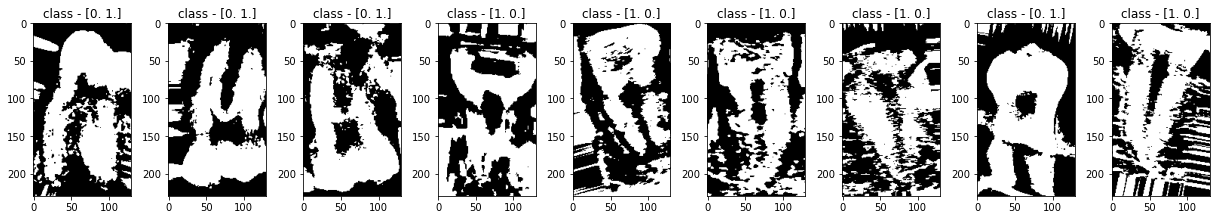

In [593]:
# test data loader

make_gen = get_generator(datafiles_df.sample(20), aug=True)
generator = make_gen()
x, y = generator.next()

n_samples = 9
fig, ax = plt.subplots(1,n_samples, figsize=(17,6))
for xi,yi,axi in zip(x[:n_samples],y[:n_samples], ax):
    axi.set_title(f"class - {yi}")
    axi.imshow(xi[:,:,0].astype("float32"), "gray")
plt.tight_layout()
plt.show()

# Train Test split & CV folds

In [594]:
# train, test = train_test_split(datafiles_df, test_size=0.2)

skf = StratifiedKFold(n_splits=5, shuffle=True)
for (t_idx, v_idx) in skf.split(datafiles_df, datafiles_df["class"]):
    train, test = datafiles_df.iloc[t_idx], datafiles_df.iloc[v_idx]
    break

In [595]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [596]:
train["class"].value_counts(), test["class"].value_counts()

(0-class-1root           52
 1-class-2ormoreroots    40
 Name: class, dtype: int64,
 0-class-1root           13
 1-class-2ormoreroots    10
 Name: class, dtype: int64)

In [597]:
folds = train.copy()
folds['kfold'] = 0

skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True)

for f, (t_idx, v_idx) in enumerate(skf.split(X=folds["filename"], y=folds["class"])):
    folds['kfold'].iloc[v_idx] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds = pd.concat([folds,pd.get_dummies(folds["class"])],1)

#folds.sample(5)
folds.groupby("kfold").agg({"kfold":"count", "0-class-1root":sum, "1-class-2ormoreroots":sum}).head()

,kfold,0-class-1root,1-class-2ormoreroots
kfold,,,
0,14,8,6
1,13,8,5
2,13,8,5
3,13,7,6
4,13,7,6


# Model Design

In [598]:
def get_model():
    K.clear_session()
    
    inputs = keras.layers.Input(shape=(230, 130, 1))
    x = keras.layers.Conv2D(64, (27,27), strides=(3,3))(inputs)
    x = keras.layers.MaxPool2D((2,2))(x)
    
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(32, (3,3),strides=(1, 1), activation="relu", kernel_regularizer=kr)(x)
    x = keras.layers.MaxPool2D((2,2))(x)
    
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(16, (3,3),strides=(1, 1), activation="relu", kernel_regularizer=kr)(x)
    x = keras.layers.MaxPool2D((2,2))(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(32, activation="relu", kernel_regularizer=kr)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(2, activation="softmax")(x)
    
    
    
    model = keras.models.Model(inputs,x)
    
    metrics=['accuracy', AUC()] 
             # Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]
    adam = keras.optimizers.Adam(lr=0.01)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=metrics)
    
    return model

model = get_model()
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230, 130, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 68, 35, 64)        46720     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 34, 17, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 15, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 7, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 7, 32)        

# Model Fitting

In [600]:
def get_callbacks(name="default"):
    callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", #val_loss 
                                             patience=cfg["early_stopping"], 
                                             mode="min",
                                             min_delta=1e-5,
                                             verbose=1, 
                                             restore_best_weights=True),

            keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model.hdf5", 
                                               verbose=1, 
                                               save_best_only=True),

            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.7,
                                                 patience=5,
                                                 verbose=1,
                                                 mode='min',
                                                 min_delta=1e-4,
                                                 cooldown=0,
                                                 min_lr=1e-5)
        ]
    return callbacks

In [602]:
def plot_lcurve(model, name="default.jpg"):
    metrics = ["loss", "auc", "accuracy"]

    fig, ax = plt.subplots(len(metrics),1, figsize=(8,6))
    for metric, axi in zip(metrics, ax):
        axi.set_title(metric)
        axi.plot(model.history.history[metric], ".--", label="tr")
        axi.plot(model.history.history[f'val_{metric}'], ".--", label="val")
        axi.legend()
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

In [603]:
def run_training(fold, seed):
    print(f"\n fold: {fold}/{NFOLDS}, seed: {seed}/{len(SEEDS)} \n")

    seed_everything(seed)

    train = folds
    trn_idx = np.where(train['kfold'] != fold)[0]
    val_idx = np.where(train['kfold'] == fold)[0]

    print( "\n Train", trn_idx, "\n Valid", val_idx, "\n\n")
    # np.intersect1d()
    
    train_gen = get_generator(train.iloc[trn_idx], aug=True)
    valid_gen = get_generator(train.iloc[val_idx], aug=False)
    test_gen = get_generator(test, aug=False)

    train_dataset = tf.data.Dataset.from_generator(train_gen,(np.float16,np.float16), output_shapes=output_shapes) # , args=("df", datafiles_df)
    validation_dataset = tf.data.Dataset.from_generator(valid_gen,(np.float16,np.float16), output_shapes=output_shapes)
    test_dataset = tf.data.Dataset.from_generator(test_gen,(np.float16,np.float16), output_shapes=output_shapes)
    
    callbacks = get_callbacks(name=f"fold_{fold}")
    model = get_model()
    model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            verbose=1,
            validation_data=validation_dataset,
            validation_steps=800 // BATCH_SIZE,
            callbacks=callbacks
    )
    learning_history[(fold, seed)] = model.history
    plot_lcurve(model, name=f"{fold}_{seed}.jpg")
    
    #--------------------- PREDICTION---------------------
    model = keras.models.load_model(filepath=f"fold_{fold}_best_model.hdf5", compile=False)
    
    predictions = np.zeros((len(test), 2))
    predictions = model.predict(test_gen(), verbose=0)
    
    valid_preds = model.predict(valid_gen(), verbose=0)
    oof[val_idx] = valid_preds
    
    return oof, predictions

In [604]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train),2))
    predictions = np.zeros((len(test),2))
    
    for fold in range(NFOLDS):
        
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions


 fold: 0/7, seed: 0/1 


 Train [ 3  4  5  6  7  8  9 11 12 13 14 16 17 18 19 20 22 23 24 26 27 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 57 58 59 60 61 63 65 66 67 68 69 71 73 74 75 76 77 78 79 80 81 82 83 85
 86 87 88 89 90 91] 
 Valid [ 0  1  2 10 15 21 25 37 56 62 64 70 72 84] 


Epoch 1/25
Found 78 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5853 - auc: 0.6115Found 14 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.67830, saving model to fold_0_best_model.hdf5
46/46 [==============================] - 26s 566ms/step - loss: 0.6767 - accuracy: 0.5853 - auc: 0.6115 - val_loss: 0.6783 - val_accuracy: 0.5000 - val_auc: 0.5765
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.7453 - auc: 0.8298Found 14 validated image filenames belonging to 2 classes.

Epoch 00002: val_loss imp

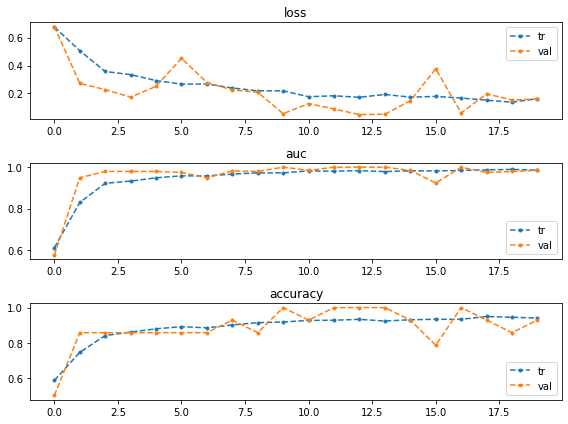

Found 23 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.

 fold: 1/7, seed: 0/1 


 Train [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 27 29 30 32 33 34 35 36 37 39 40 42 43 44 45 46 47 48 49 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 75 76 78 79 80 81 83 84
 85 86 87 88 89 90 91] 
 Valid [ 7 17 26 28 31 38 41 50 71 73 74 77 82] 


Epoch 1/25
Found 79 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6145 - auc: 0.6675Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.51597, saving model to fold_1_best_model.hdf5
46/46 [==============================] - 29s 632ms/step - loss: 0.6420 - accuracy: 0.6145 - auc: 0.6675 - val_loss: 0.5160 - val_accuracy: 0.9231 - val_auc: 0.8580
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.4208

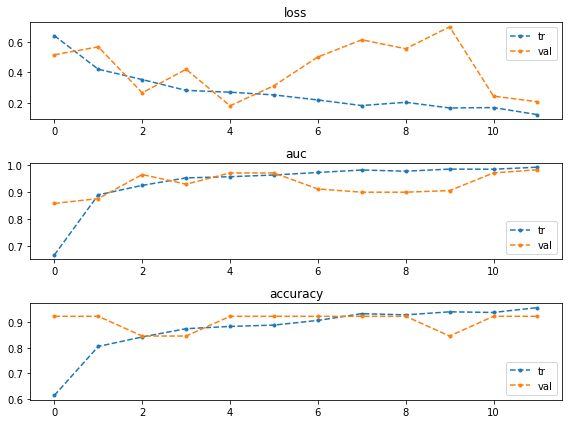

Found 23 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.

 fold: 2/7, seed: 0/1 


 Train [ 0  1  2  3  4  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 47 49 50 52 53 54 56
 57 58 59 60 61 62 64 65 67 68 69 70 71 72 73 74 76 77 78 79 81 82 83 84
 85 86 87 88 89 90 91] 
 Valid [ 5  6  9 30 32 46 48 51 55 63 66 75 80] 


Epoch 1/25
Found 79 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.5691 - auc: 0.5918Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.53801, saving model to fold_2_best_model.hdf5
46/46 [==============================] - 29s 627ms/step - loss: 0.6831 - accuracy: 0.5691 - auc: 0.5918 - val_loss: 0.5380 - val_accuracy: 0.8462 - val_auc: 0.9763
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.6068

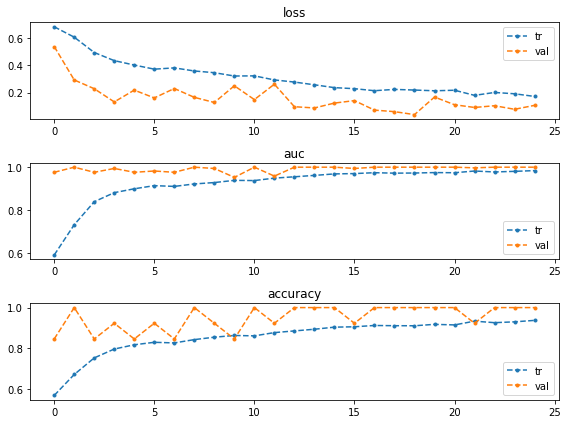

Found 23 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.

 fold: 3/7, seed: 0/1 


 Train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 25 26 27
 28 29 30 31 32 33 34 35 37 38 39 40 41 42 44 45 46 48 49 50 51 52 55 56
 58 59 60 61 62 63 64 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82
 84 85 86 87 89 90 91] 
 Valid [13 22 23 24 36 43 47 53 54 57 65 83 88] 


Epoch 1/25
Found 79 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.6282 - auc: 0.6803Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.36235, saving model to fold_3_best_model.hdf5
46/46 [==============================] - 28s 607ms/step - loss: 0.6399 - accuracy: 0.6282 - auc: 0.6803 - val_loss: 0.3623 - val_accuracy: 0.7692 - val_auc: 0.9467
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.4458

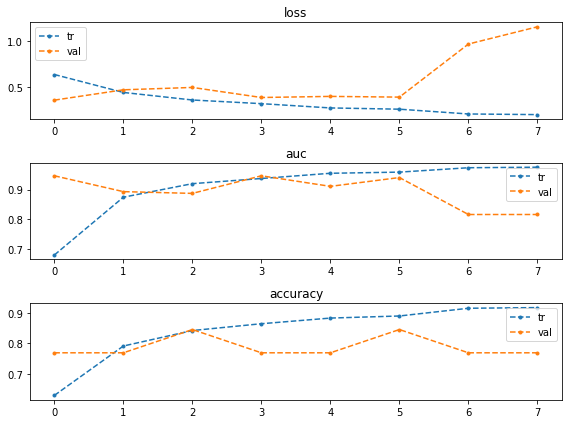

Found 23 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.

 fold: 4/7, seed: 0/1 


 Train [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 30 31 32 34 35 36 37 38 39 40 41 43 44 45 46 47 48 50 51 52 53 54
 55 56 57 59 60 62 63 64 65 66 67 68 70 71 72 73 74 75 76 77 78 80 81 82
 83 84 85 86 88 90 91] 
 Valid [ 8 18 20 29 33 42 49 58 61 69 79 87 89] 


Epoch 1/25
Found 79 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.6577 - auc: 0.7156Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.48941, saving model to fold_4_best_model.hdf5
46/46 [==============================] - 28s 608ms/step - loss: 0.6195 - accuracy: 0.6577 - auc: 0.7156 - val_loss: 0.4894 - val_accuracy: 0.7692 - val_auc: 0.8935
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.4522

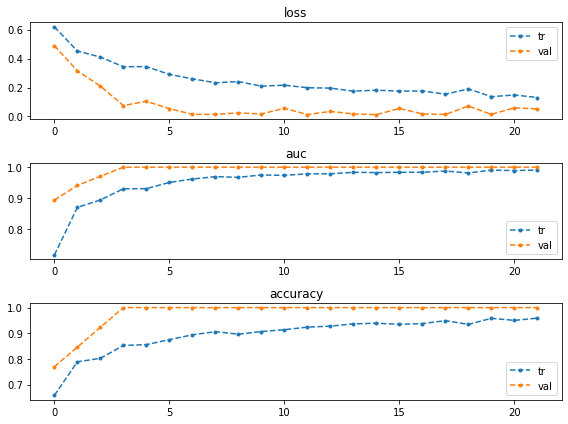

Found 23 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.

 fold: 5/7, seed: 0/1 


 Train [ 0  1  2  3  5  6  7  8  9 10 13 15 16 17 18 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 69 70 71 72 73 74 75 76 77 79 80
 82 83 84 86 87 88 89] 
 Valid [ 4 11 12 14 19 40 45 68 78 81 85 90 91] 


Epoch 1/25
Found 79 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5682 - auc: 0.5640Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.69300, saving model to fold_5_best_model.hdf5
46/46 [==============================] - 28s 604ms/step - loss: 0.6887 - accuracy: 0.5682 - auc: 0.5640 - val_loss: 0.6930 - val_accuracy: 0.5385 - val_auc: 0.5385
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.6844

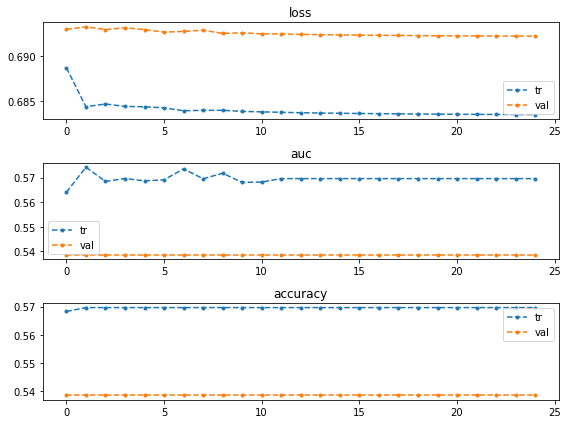

Found 23 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.

 fold: 6/7, seed: 0/1 


 Train [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 28 29 30 31 32 33 36 37 38 40 41 42 43 45 46 47 48 49 50 51 53 54 55
 56 57 58 61 62 63 64 65 66 68 69 70 71 72 73 74 75 77 78 79 80 81 82 83
 84 85 87 88 89 90 91] 
 Valid [ 3 16 27 34 35 39 44 52 59 60 67 76 86] 


Epoch 1/25
Found 79 validated image filenames belonging to 2 classes.
46/46 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.5795 - auc: 0.6120Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.71151, saving model to fold_6_best_model.hdf5
46/46 [==============================] - 27s 594ms/step - loss: 0.6742 - accuracy: 0.5795 - auc: 0.6120 - val_loss: 0.7115 - val_accuracy: 0.3846 - val_auc: 0.5325
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.5084

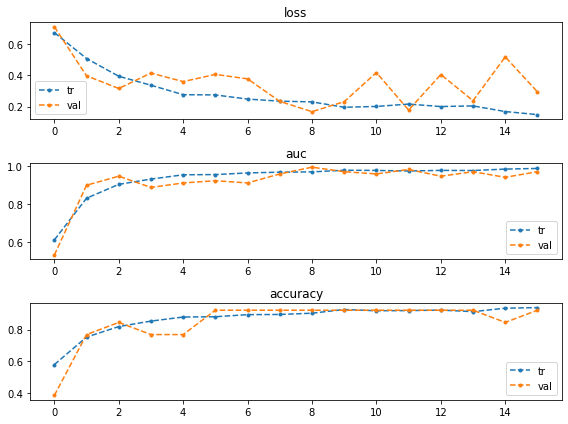

Found 23 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [605]:
oof = np.zeros((len(train),2))
predictions = np.zeros((len(test),2))

learning_history = {}

for seed in SEEDS:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEEDS)
    predictions += predictions_ / len(SEEDS)
    gc.collect()

# Learning Curve

In [606]:
dfs = []
for k,v in learning_history.items():
    df_ = pd.DataFrame(v.history)
    df_["fold"] = k[0]
    df_["seed"] = k[1]
    dfs.append(df_)
    
learning_history_df = pd.concat(dfs)
learning_history_df.to_csv("learning_history_df.csv")
learning_history_df.groupby(["seed","fold"]).agg({"val_loss":min})

val_loss
seed fold          
0    0     0.047771
     1     0.180104
     2     0.037662
     3     0.362348
     4     0.012759
     5     0.692253
     6     0.167977

In [625]:
pd.DataFrame(predictions).to_csv("predictions.csv")
pd.DataFrame(oof).to_csv("oof.csv")

# Evaluation

In [622]:
# test

test_y = pd.get_dummies(test["class"]).values
pred_y = predictions
cr = classification_report(test_y.argmax(1), pred_y.argmax(1))
print(cr)

correct_classified = (test_y.argmax(1) == pred_y.argmax(1)).sum()
total_samples = test_y.shape[0]
print(color_back(
    f"Accuracy: {np.round(correct_classified/total_samples, 2)}, {correct_classified}/{total_samples}\n" \
    f"Crossentropy {np.round(keras.metrics.categorical_crossentropy(test_y, pred_y).numpy().mean(), 4)}",
     255,255,0))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.90      0.90      0.90        10

    accuracy                           0.91        23
   macro avg       0.91      0.91      0.91        23
weighted avg       0.91      0.91      0.91        23

Accuracy: 0.91, 21/23
Crossentropy 0.2972
